天顶延迟符合要求：-3.05e-04 s (<= 7.69 ns)


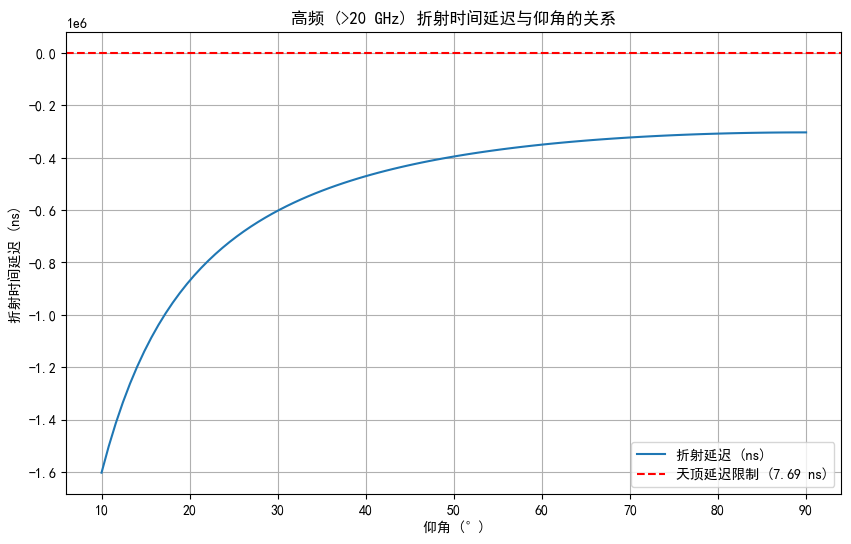

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置matplotlib使用支持中文的字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 常量定义
c = 3e8  # 光速 (m/s)
f_threshold = 20e9  # 频率阈值 (20 GHz)
zenith_delay_threshold = 7.69e-9  # 天顶延迟限制 (7.69 ns)

# 折射率模型函数 (简化的干折射率)
def refractive_index(h):
    """
    返回高度 h (单位: m) 对应的大气折射率 n(h)
    """
    # 假设的干折射率分布（高度越高，n(h) 越接近 1）
    # 参数可根据实际情况调整
    n0 = 1.0003  # 地表折射率
    scale_height = 8500  # 干空气的尺度高度 (m)
    return n0 * np.exp(-h / scale_height)

# 折射延迟积分函数
def refractive_delay(elevation_angle, h0, h1):
    """
    计算从 h0 到 h1 的折射时间延迟
    elevation_angle: 仰角 (弧度)
    h0: 起始高度 (m)
    h1: 结束高度 (m)
    """
    # 传播路径函数
    def path_integral(h):
        return (refractive_index(h) - 1)

    # 积分计算折射延迟
    delay, _ = quad(path_integral, h0, h1)
    return delay / c / np.sin(elevation_angle)  # 除以传播路径长度

# 映射函数
def mapping_function(elevation_angle, a=0.0029, b=0.0001, c=0.00002):
    """
    映射函数，调整非天顶方向的延迟
    elevation_angle: 仰角 (弧度)
    """
    return 1 / (np.sin(elevation_angle) + a / (np.sin(elevation_angle) + b + c))

# 参数设置
elevation_angles = np.linspace(np.radians(10), np.radians(90), 100)  # 仰角从10°到90°（天顶）
h0 = 0  # 地表高度 (m)
h1 = 100000  # 大气层高度上限 (m)

# 计算折射延迟
delays = []
for angle in elevation_angles:
    zenith_delay = refractive_delay(np.pi / 2, h0, h1)  # 天顶延迟
    mapped_delay = zenith_delay * mapping_function(angle)
    delays.append(mapped_delay)

# 检查天顶延迟是否满足限制
zenith_delay = refractive_delay(np.pi / 2, h0, h1)
if zenith_delay > zenith_delay_threshold:
    print(f"天顶延迟超过限制：{zenith_delay:.2e} s (> 7.69 ns)")
else:
    print(f"天顶延迟符合要求：{zenith_delay:.2e} s (<= 7.69 ns)")

# 绘制延迟与仰角的关系
plt.figure(figsize=(10, 6))
plt.plot(np.degrees(elevation_angles), np.array(delays) * 1e9, label="折射延迟 (ns)")
plt.axhline(zenith_delay_threshold * 1e9, color="r", linestyle="--", label="天顶延迟限制 (7.69 ns)")
plt.xlabel("仰角 (°)")
plt.ylabel("折射时间延迟 (ns)")
plt.title("高频 (>20 GHz) 折射时间延迟与仰角的关系")
plt.legend()
plt.grid(True)
plt.show()
